In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install catboost
!pip install mlxtend  
!pip install scikit-learn
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

     |████████████████████████████████| 76.6 MB 50 kB/s 
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from collections import Counter
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action="ignore")
import six
import sys
sys.modules['sklearn.externals.six'] = six

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

import sklearn
import xgboost as xgb
from sklearn import tree
from sklearn.svm import SVC
from sklearn.metrics import roc_curve
from imblearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report
from mlxtend.classifier import StackingCVClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import recall_score, f1_score, roc_auc_score
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score

In [ ]:
bank_data = pd.read_csv("/content/drive/MyDrive/data.csv")
bank_data.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [ ]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [ ]:
[print(col) for col in bank_data if bank_data[col].isna().sum() > 0]

[]

In [ ]:
bank_data.duplicated().sum()

0

In [ ]:
print(bank_data['Bankrupt?'].value_counts())
print('-'* 30)
print('Financially stable: ', round(bank_data['Bankrupt?'].value_counts()[0]/len(bank_data) * 100,2), '% of the dataset')
print('Financially unstable: ', round(bank_data['Bankrupt?'].value_counts()[1]/len(bank_data) * 100,2), '% of the dataset')

0    6599
1     220
Name: Bankrupt?, dtype: int64
------------------------------
Financially stable:  96.77 % of the dataset
Financially unstable:  3.23 % of the dataset


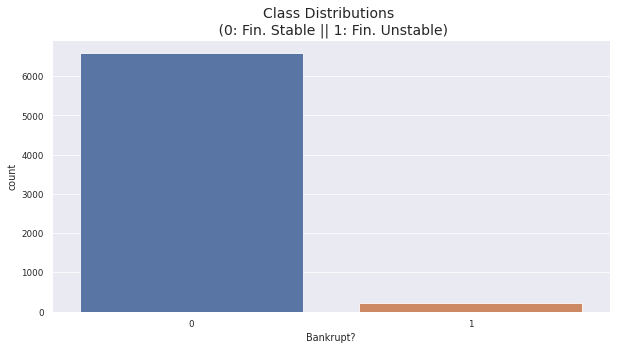

In [ ]:
sns.set_theme(context = 'paper')

plt.figure(figsize = (10,5))
sns.countplot(bank_data['Bankrupt?'])
plt.title('Class Distributions \n (0: Fin. Stable || 1: Fin. Unstable)', fontsize=14)
plt.show()

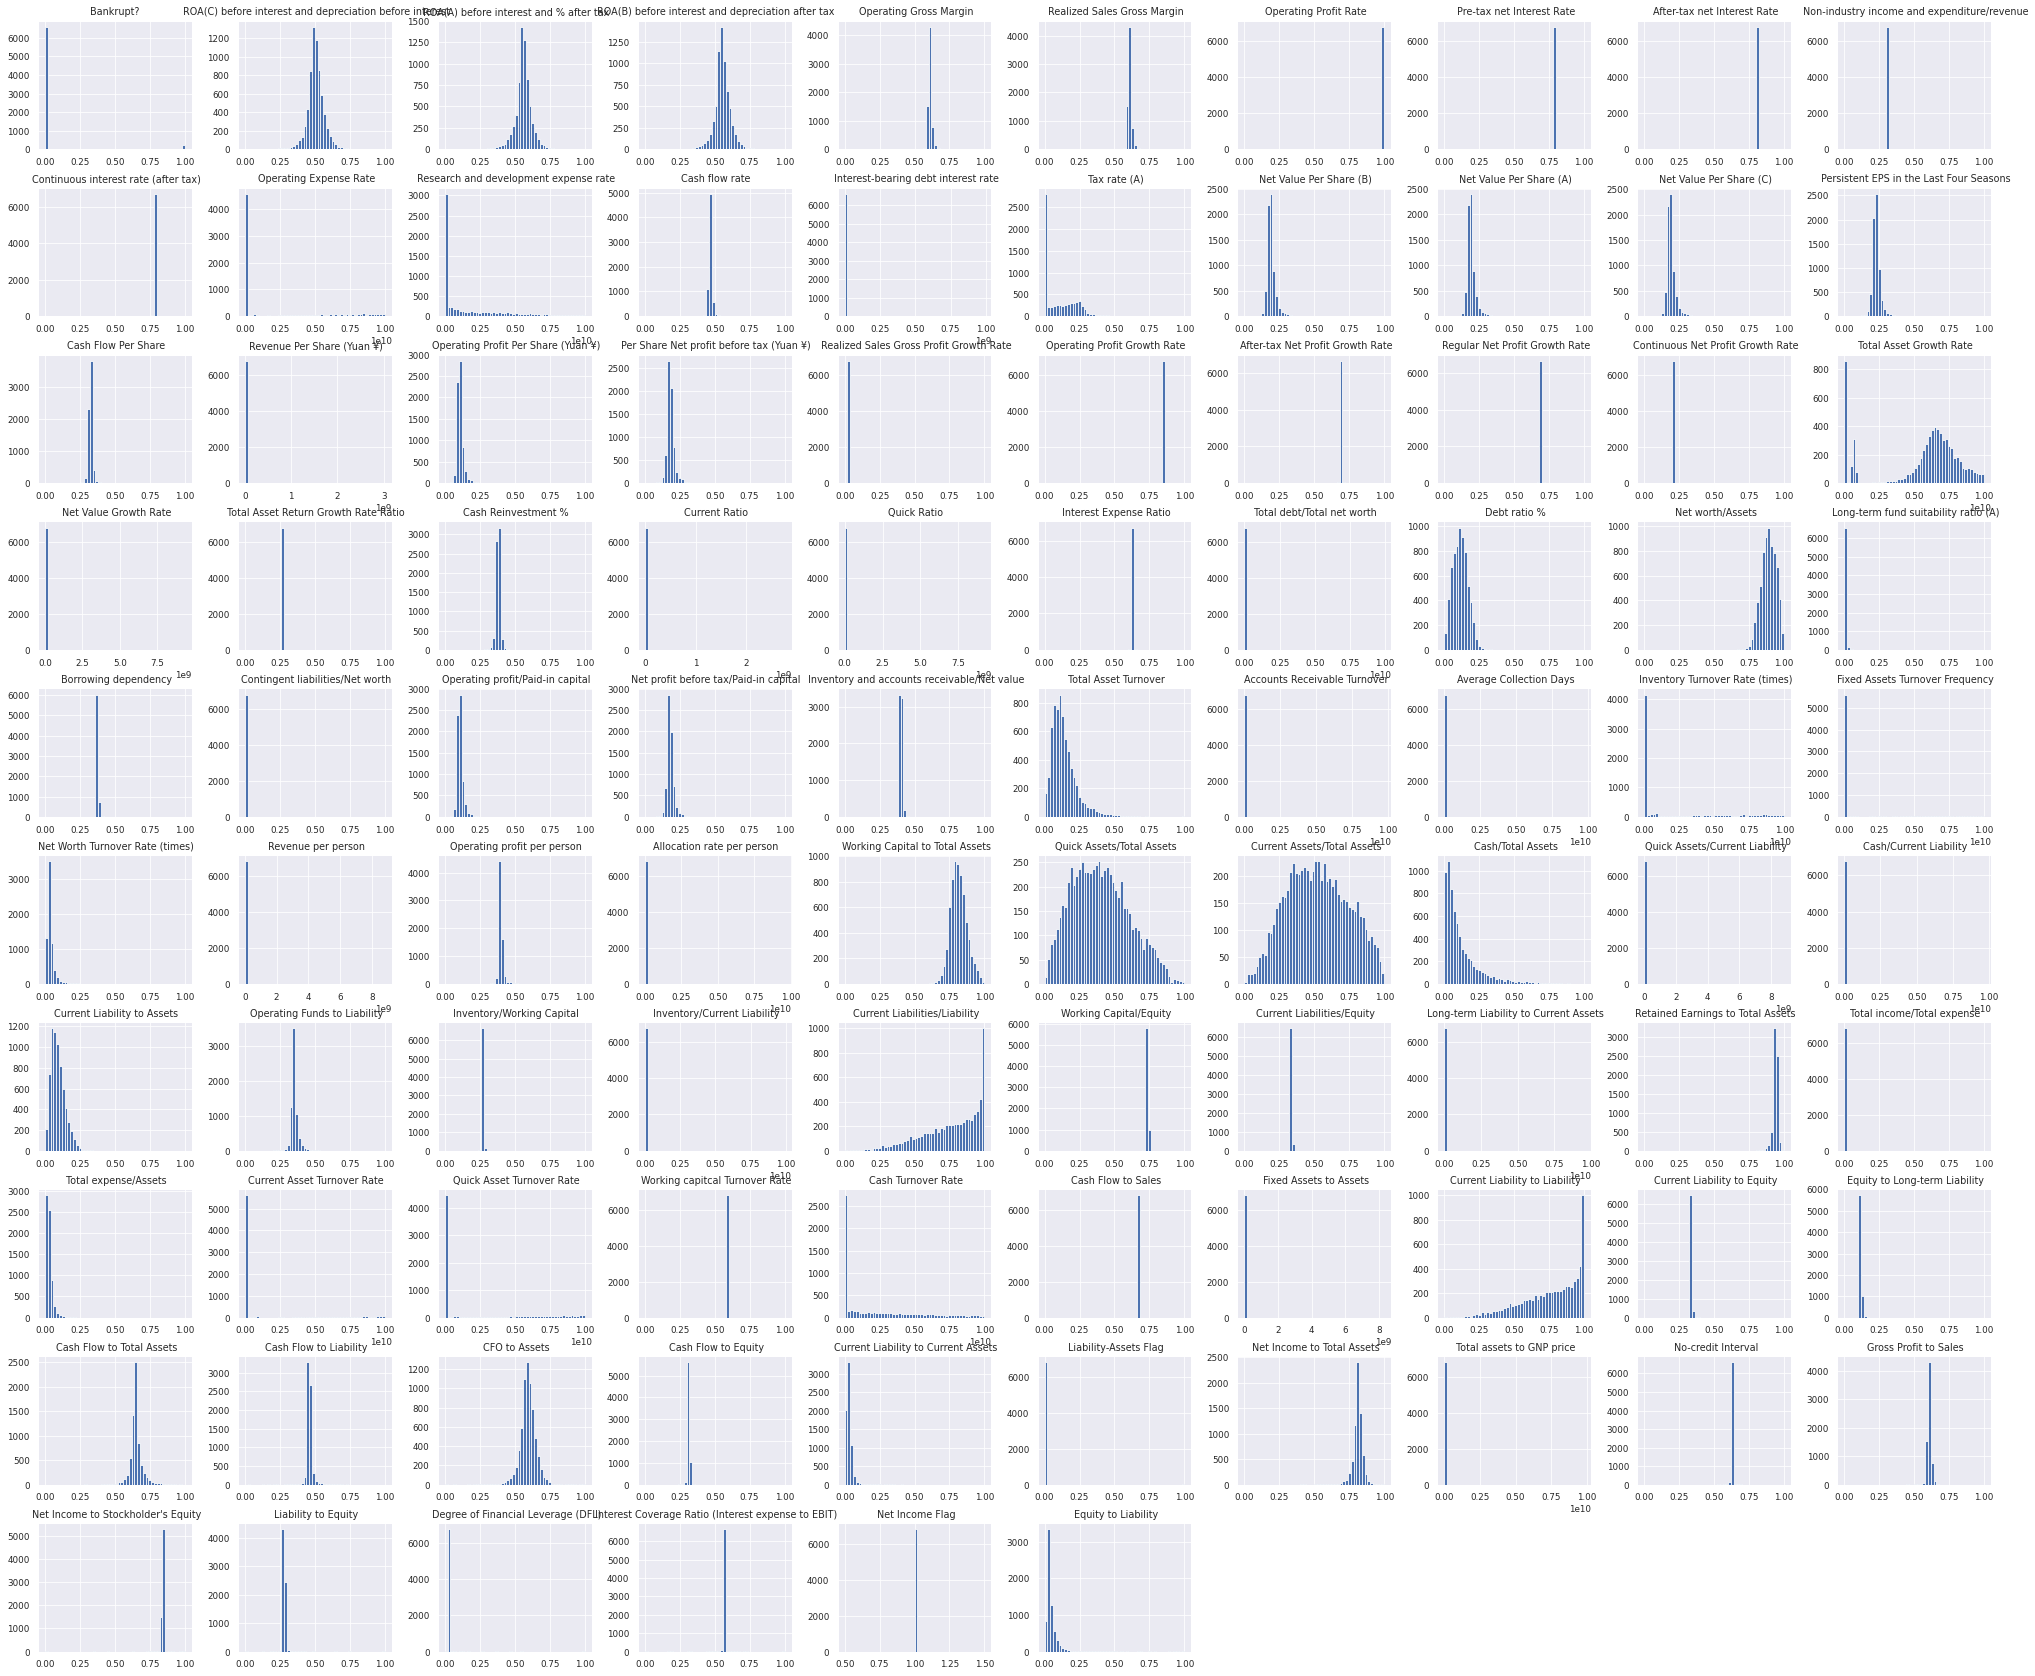

In [ ]:
bank_data.hist(figsize = (35,30), bins = 50)
plt.show()

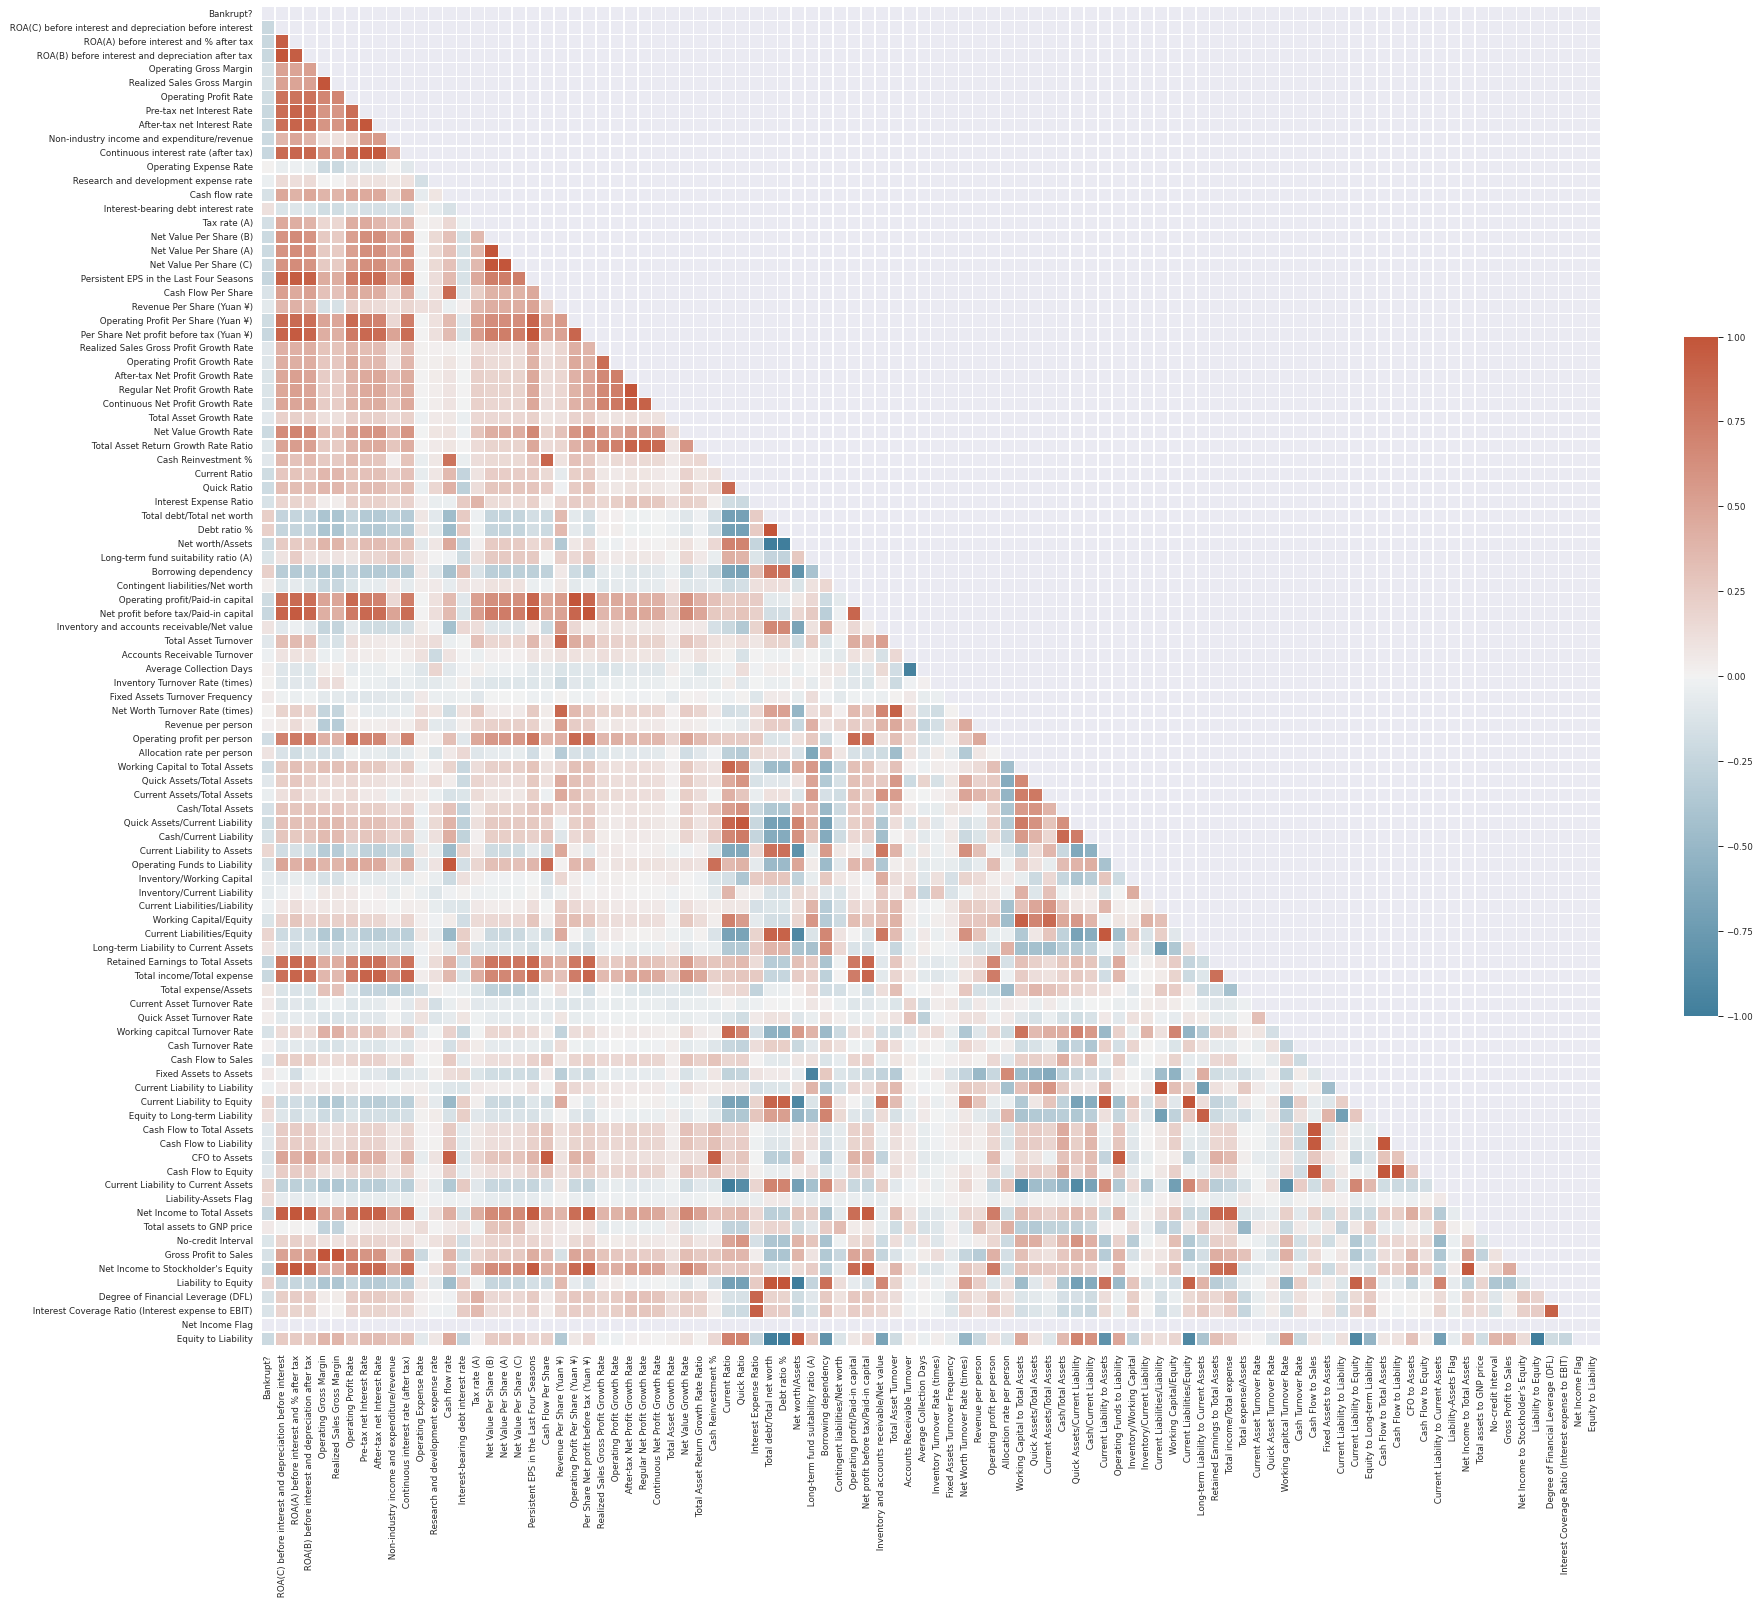

In [ ]:
f, ax = plt.subplots(figsize=(30, 25))
mat = bank_data.corr('spearman')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

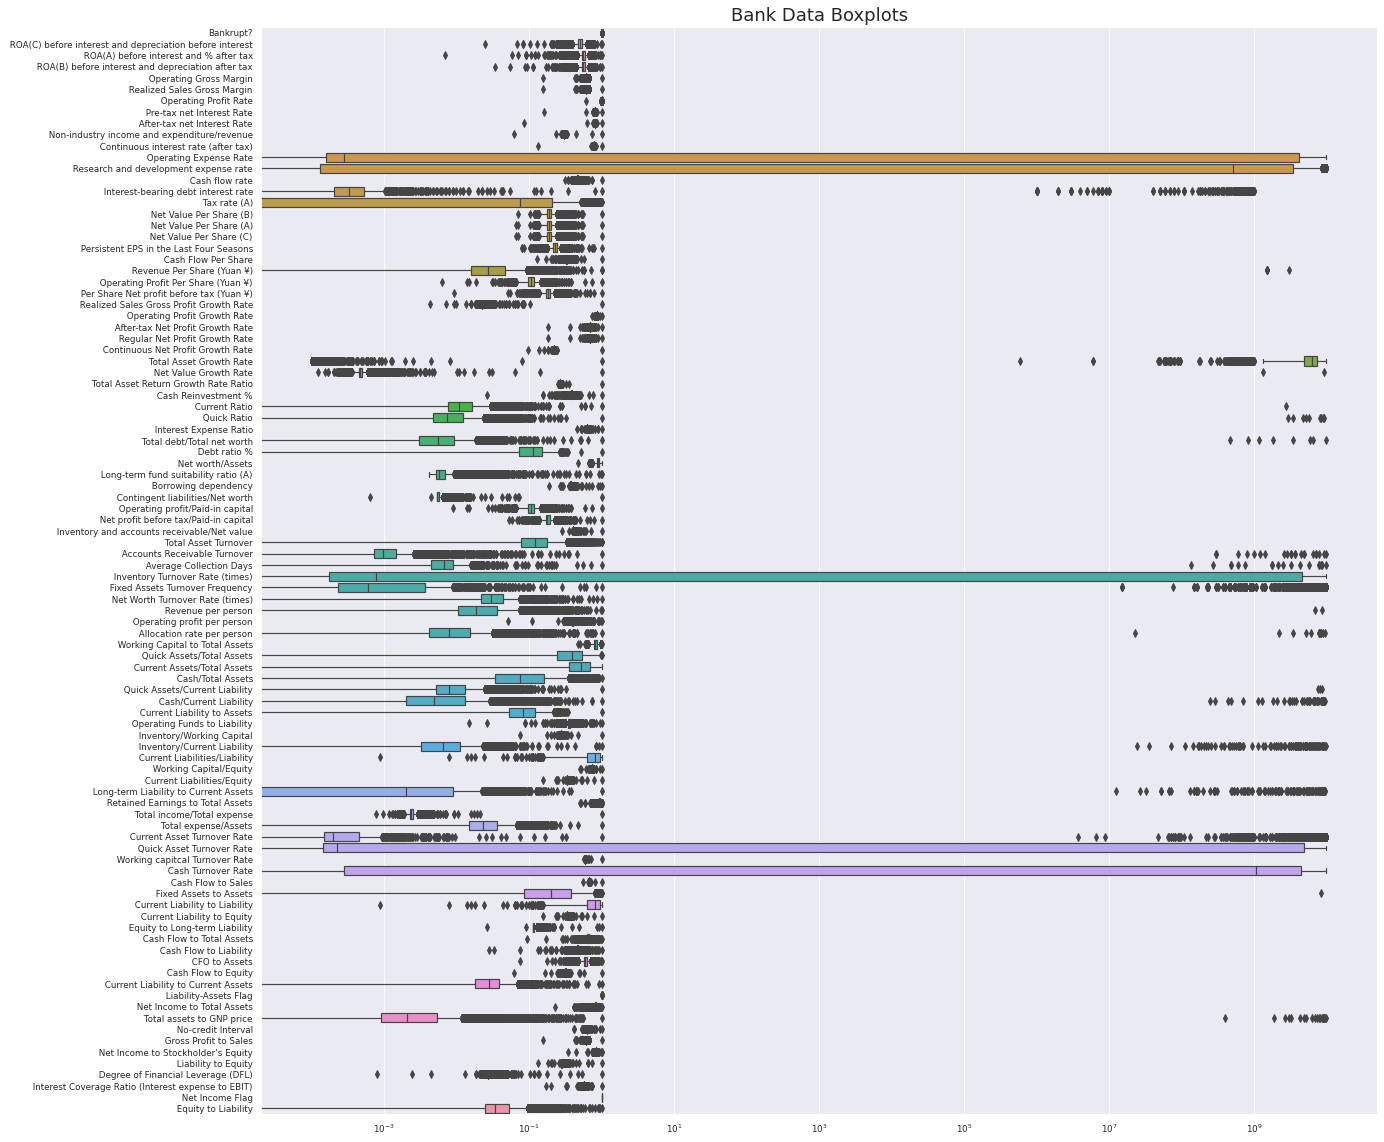

In [ ]:
plt.figure(figsize = (20,20))
ax =sns.boxplot(data = bank_data, orient="h")
ax.set_title('Bank Data Boxplots', fontsize = 18)
ax.set(xscale="log")
plt.show()

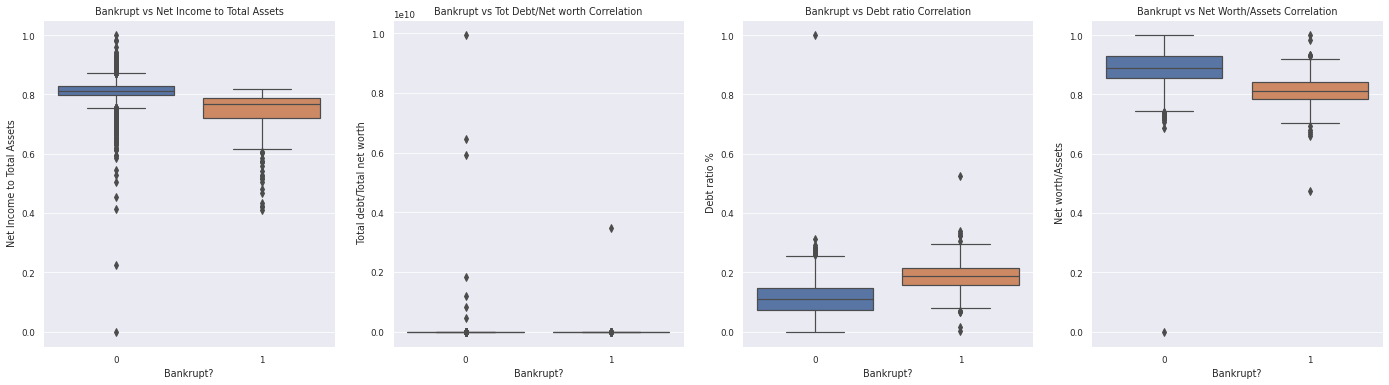

In [ ]:
f, axes = plt.subplots(ncols=4, figsize=(24,6))

sns.boxplot(x='Bankrupt?', y=" Net Income to Total Assets", data=bank_data, ax=axes[0])
axes[0].set_title('Bankrupt vs Net Income to Total Assets')

sns.boxplot(x='Bankrupt?', y=" Total debt/Total net worth", data=bank_data, ax=axes[1]) 
axes[1].set_title('Bankrupt vs Tot Debt/Net worth Correlation')


sns.boxplot(x='Bankrupt?', y=" Debt ratio %", data=bank_data, ax=axes[2])
axes[2].set_title('Bankrupt vs Debt ratio Correlation')


sns.boxplot(x='Bankrupt?', y=" Net worth/Assets", data=bank_data, ax=axes[3])  
axes[3].set_title('Bankrupt vs Net Worth/Assets Correlation') 

plt.show()

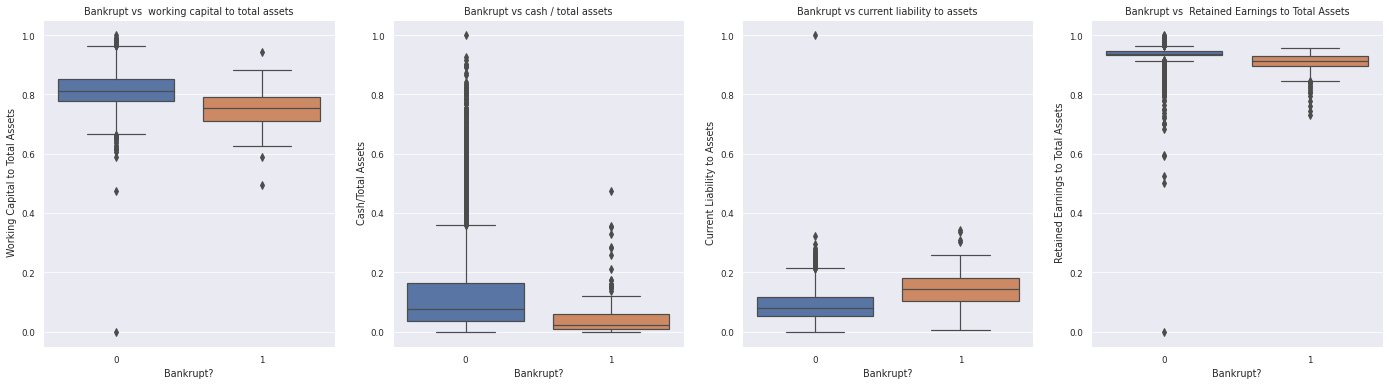

In [ ]:
f, axes = plt.subplots(ncols=4, figsize=(24,6))

sns.boxplot(x='Bankrupt?', y=" Working Capital to Total Assets", data=bank_data, ax=axes[0])
axes[0].set_title('Bankrupt vs  working capital to total assets')

sns.boxplot(x='Bankrupt?', y=" Cash/Total Assets", data=bank_data, ax=axes[1])
axes[1].set_title('Bankrupt vs cash / total assets')


sns.boxplot(x='Bankrupt?', y=" Current Liability to Assets", data=bank_data, ax=axes[2])
axes[2].set_title('Bankrupt vs current liability to assets')


sns.boxplot(x='Bankrupt?', y=" Retained Earnings to Total Assets", data=bank_data, ax=axes[3])
axes[3].set_title('Bankrupt vs  Retained Earnings to Total Assets')

plt.show()

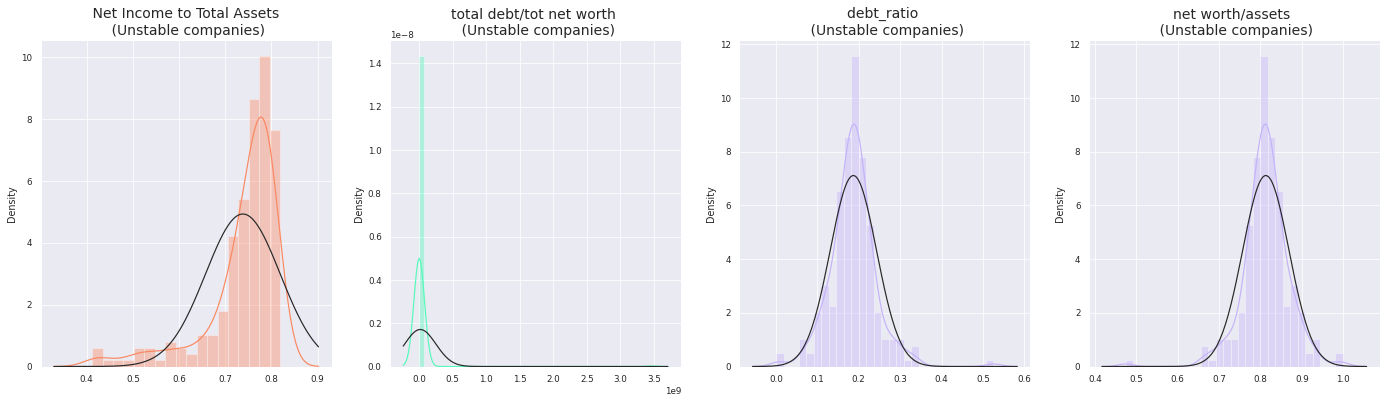

In [ ]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(24, 6))

cash_flow_rate = bank_data[' Net Income to Total Assets'].loc[bank_data['Bankrupt?'] == 1].values
sns.distplot(cash_flow_rate,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title(' Net Income to Total Assets \n (Unstable companies)', fontsize=14)

tot_debt_net = bank_data[' Total debt/Total net worth'].loc[bank_data['Bankrupt?'] == 1].values
sns.distplot(tot_debt_net ,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('total debt/tot net worth \n (Unstable companies)', fontsize=14)


debt_ratio = bank_data[' Debt ratio %'].loc[bank_data['Bankrupt?'] == 1].values
sns.distplot(debt_ratio,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('debt_ratio \n (Unstable companies)', fontsize=14)

net_worth_assets = bank_data[' Net worth/Assets'].loc[bank_data['Bankrupt?'] == 1].values
sns.distplot(net_worth_assets,ax=ax4, fit=norm, color='#C5B3F9')
ax4.set_title('net worth/assets \n (Unstable companies)', fontsize=14)

plt.show()

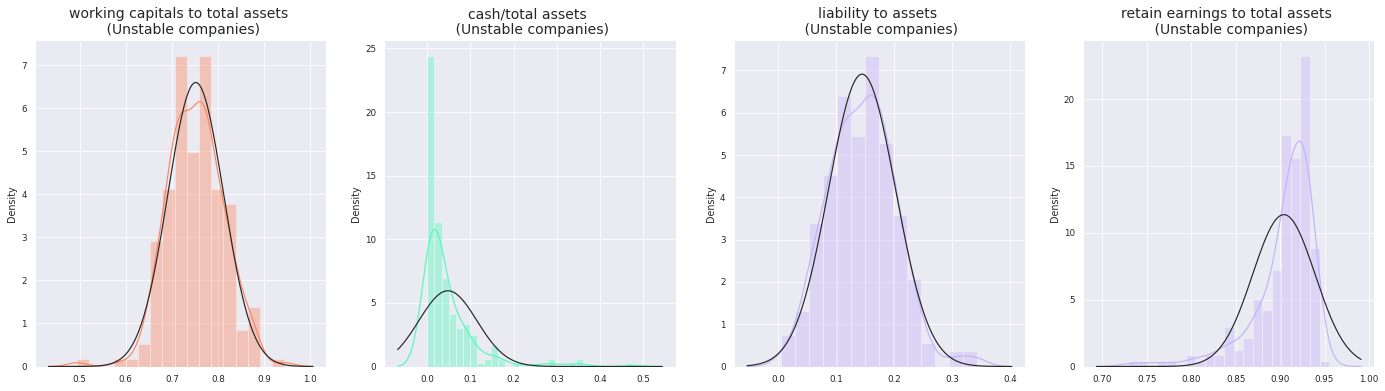

In [ ]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(24, 6))

working_cap = bank_data[' Working Capital to Total Assets'].loc[bank_data['Bankrupt?'] == 1].values
sns.distplot(working_cap,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('working capitals to total assets \n (Unstable companies)', fontsize=14)

cash_tot_assets = bank_data[' Cash/Total Assets'].loc[bank_data['Bankrupt?'] == 1].values
sns.distplot(cash_tot_assets ,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('cash/total assets \n (Unstable companies)', fontsize=14)


asset_liab = bank_data[' Current Liability to Assets'].loc[bank_data['Bankrupt?'] == 1].values
sns.distplot(asset_liab,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('liability to assets \n (Unstable companies)', fontsize=14)

operating_funds = bank_data[' Retained Earnings to Total Assets'].loc[bank_data['Bankrupt?'] == 1].values
sns.distplot(operating_funds,ax=ax4, fit=norm, color='#C5B3F9')
ax4.set_title('retain earnings to total assets \n (Unstable companies)', fontsize=14)

plt.show()

In [ ]:
def outliers_removal(feature,feature_name,dataset):
    q25, q75 = np.percentile(feature, 25), np.percentile(feature, 75)
    print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
    feat_iqr = q75 - q25
    print('iqr: {}'.format(feat_iqr))
    
    feat_cut_off = feat_iqr * 1.5
    feat_lower, feat_upper = q25 - feat_cut_off, q75 + feat_cut_off
    print('Cut Off: {}'.format(feat_cut_off))
    print(feature_name +' Lower: {}'.format(feat_lower))
    print(feature_name +' Upper: {}'.format(feat_upper))
    
    outliers = [x for x in feature if x < feat_lower or x > feat_upper]
    print(feature_name + ' outliers for close to bankruptcy cases: {}'.format(len(outliers)))

    dataset = dataset.drop(dataset[(dataset[feature_name] > feat_upper) | (dataset[feature_name] < feat_lower)].index)
    print('-' * 65)
    
    return dataset

for col in bank_data:
    new_df = outliers_removal(bank_data[col],str(col),bank_data)

Quartile 25: 0.0 | Quartile 75: 0.0
iqr: 0.0
Cut Off: 0.0
Bankrupt? Lower: 0.0
Bankrupt? Upper: 0.0
Bankrupt? outliers for close to bankruptcy cases: 220
-----------------------------------------------------------------
Quartile 25: 0.476527080388047 | Quartile 75: 0.535562813825379
iqr: 0.05903573343733198
Cut Off: 0.08855360015599797
 ROA(C) before interest and depreciation before interest Lower: 0.38797348023204903
 ROA(C) before interest and depreciation before interest Upper: 0.624116413981377
 ROA(C) before interest and depreciation before interest outliers for close to bankruptcy cases: 391
-----------------------------------------------------------------
Quartile 25: 0.53554295682512 | Quartile 75: 0.58915721761884
iqr: 0.05361426079372
Cut Off: 0.08042139119058
 ROA(A) before interest and % after tax Lower: 0.45512156563454
 ROA(A) before interest and % after tax Upper: 0.66957860880942
 ROA(A) before interest and % after tax outliers for close to bankruptcy cases: 561
-------

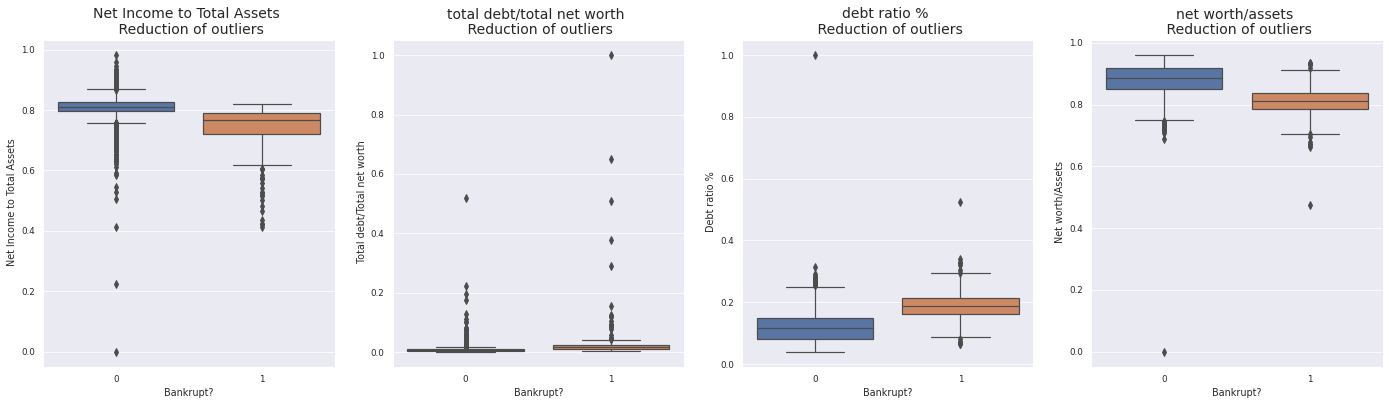

In [ ]:
f,(ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24,6))

sns.boxplot(x="Bankrupt?", y=" Net Income to Total Assets", data=new_df,ax=ax1) 
ax1.set_title("Net Income to Total Assets \n Reduction of outliers", fontsize=14)

sns.boxplot(x="Bankrupt?", y=" Total debt/Total net worth", data=new_df,ax=ax2) 
ax2.set_title("total debt/total net worth \n Reduction of outliers", fontsize=14)

sns.boxplot(x="Bankrupt?", y=" Debt ratio %", data=new_df,ax=ax3) 
ax3.set_title("debt ratio % \n Reduction of outliers", fontsize=14)

sns.boxplot(x="Bankrupt?", y=' Net worth/Assets', data=new_df,ax=ax4) 
ax4.set_title("net worth/assets \n Reduction of outliers", fontsize=14)
        
plt.show()

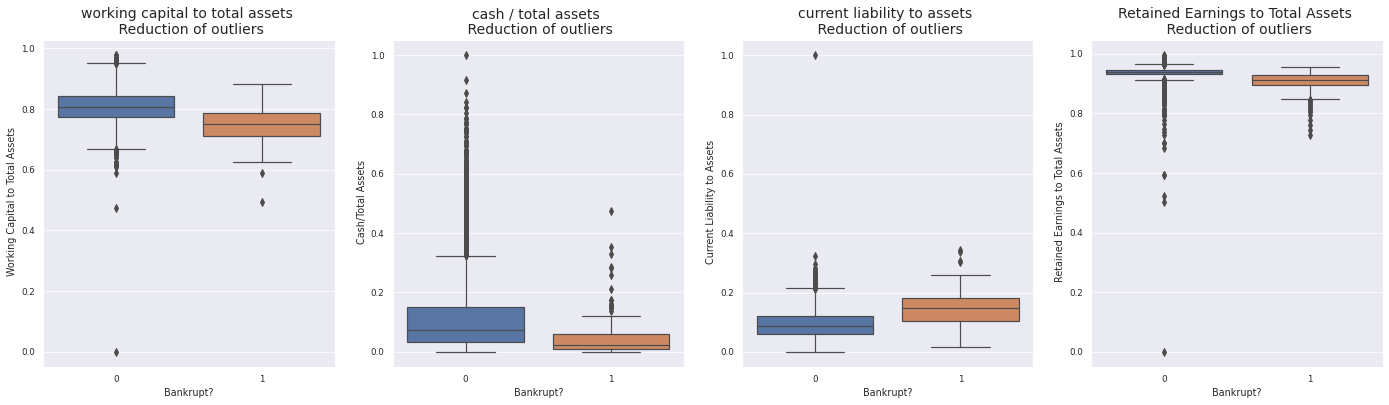

In [ ]:
f,(ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24,6))

sns.boxplot(x="Bankrupt?", y=' Working Capital to Total Assets', data=new_df,ax=ax1) 
ax1.set_title("working capital to total assets \n Reduction of outliers", fontsize=14)

sns.boxplot(x="Bankrupt?", y=' Cash/Total Assets', data=new_df,ax=ax2) 
ax2.set_title("cash / total assets \n Reduction of outliers", fontsize=14)

sns.boxplot(x="Bankrupt?", y=' Current Liability to Assets', data=new_df,ax=ax3) 
ax3.set_title("current liability to assets \n Reduction of outliers", fontsize=14)

sns.boxplot(x="Bankrupt?", y=' Retained Earnings to Total Assets', data=new_df,ax=ax4) 
ax4.set_title("Retained Earnings to Total Assets \n Reduction of outliers", fontsize=14)
        
plt.show()

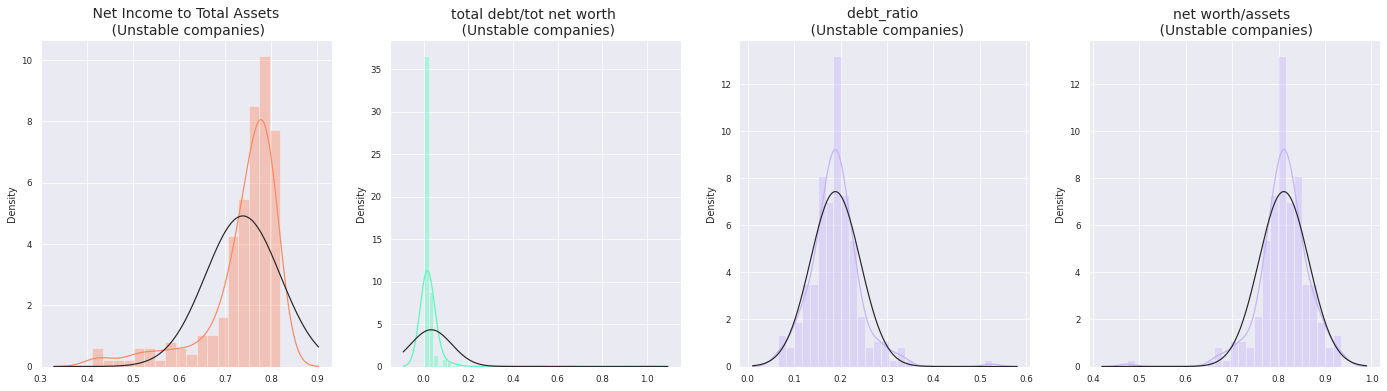

In [ ]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(24, 6))

cash_flow_rate = new_df[' Net Income to Total Assets'].loc[new_df['Bankrupt?'] == 1].values
sns.distplot(cash_flow_rate,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title(' Net Income to Total Assets \n (Unstable companies)', fontsize=14)

tot_debt_net = new_df[' Total debt/Total net worth'].loc[new_df['Bankrupt?'] == 1].values
sns.distplot(tot_debt_net ,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('total debt/tot net worth \n (Unstable companies)', fontsize=14)


debt_ratio = new_df[' Debt ratio %'].loc[new_df['Bankrupt?'] == 1].values
sns.distplot(debt_ratio,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('debt_ratio \n (Unstable companies)', fontsize=14)

net_worth_assets = new_df[' Net worth/Assets'].loc[new_df['Bankrupt?'] == 1].values
sns.distplot(net_worth_assets,ax=ax4, fit=norm, color='#C5B3F9')
ax4.set_title('net worth/assets \n (Unstable companies)', fontsize=14)

plt.show()

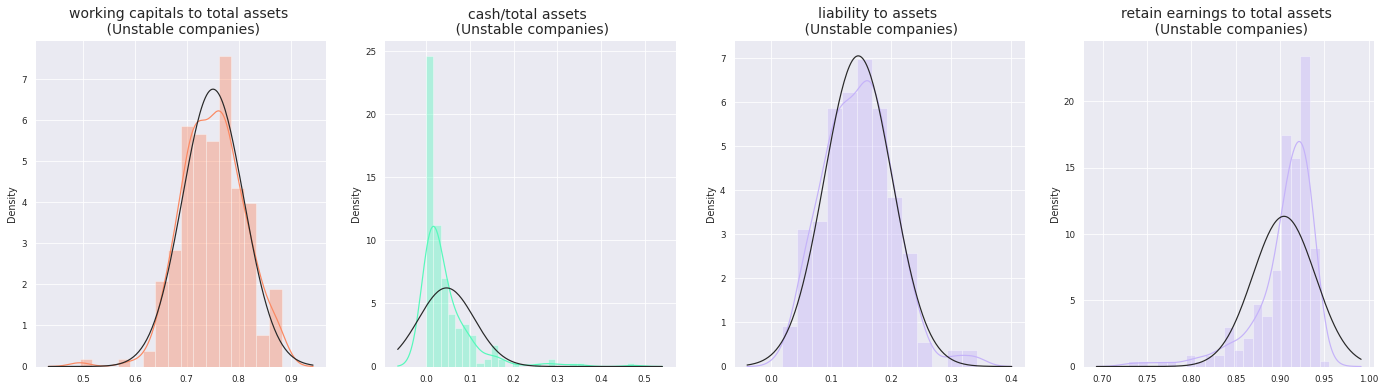

In [ ]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(24, 6))

working_cap = new_df[' Working Capital to Total Assets'].loc[new_df['Bankrupt?'] == 1].values
sns.distplot(working_cap,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('working capitals to total assets \n (Unstable companies)', fontsize=14)

cash_tot_assets = new_df[' Cash/Total Assets'].loc[new_df['Bankrupt?'] == 1].values
sns.distplot(cash_tot_assets ,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('cash/total assets \n (Unstable companies)', fontsize=14)


asset_liab = new_df[' Current Liability to Assets'].loc[new_df['Bankrupt?'] == 1].values
sns.distplot(asset_liab,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('liability to assets \n (Unstable companies)', fontsize=14)

operating_funds = new_df[' Retained Earnings to Total Assets'].loc[new_df['Bankrupt?'] == 1].values
sns.distplot(operating_funds,ax=ax4, fit=norm, color='#C5B3F9')
ax4.set_title('retain earnings to total assets \n (Unstable companies)', fontsize=14)

plt.show()

In [ ]:
labels = new_df['Bankrupt?']
new_df = new_df.drop(['Bankrupt?'], axis = 1)

In [ ]:
def log_trans(data):
    
    for col in data:
        skew = data[col].skew()
        if skew > 0.5 or skew < -0.5:
            data[col] = np.log1p(data[col])
        else:
            continue
            
    return data

data_norm = log_trans(new_df)

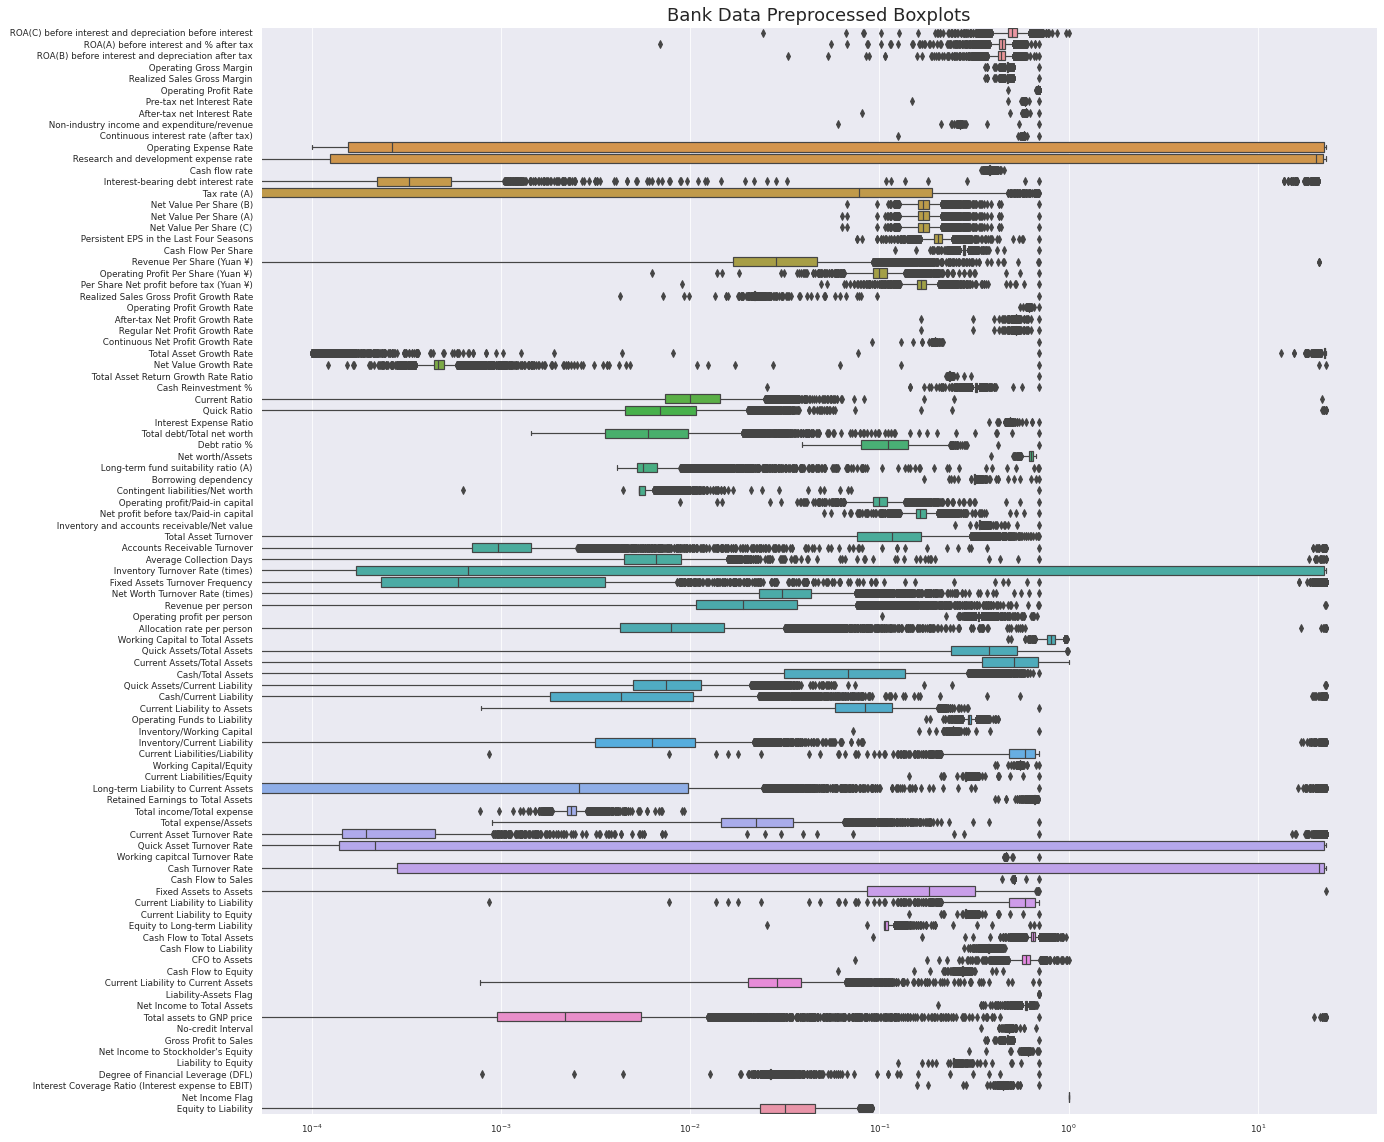

In [ ]:
plt.figure(figsize = (20,20))
ax =sns.boxplot(data = data_norm, orient="h")
ax.set_title('Bank Data Preprocessed Boxplots', fontsize = 18)
ax.set(xscale="log")
plt.show()

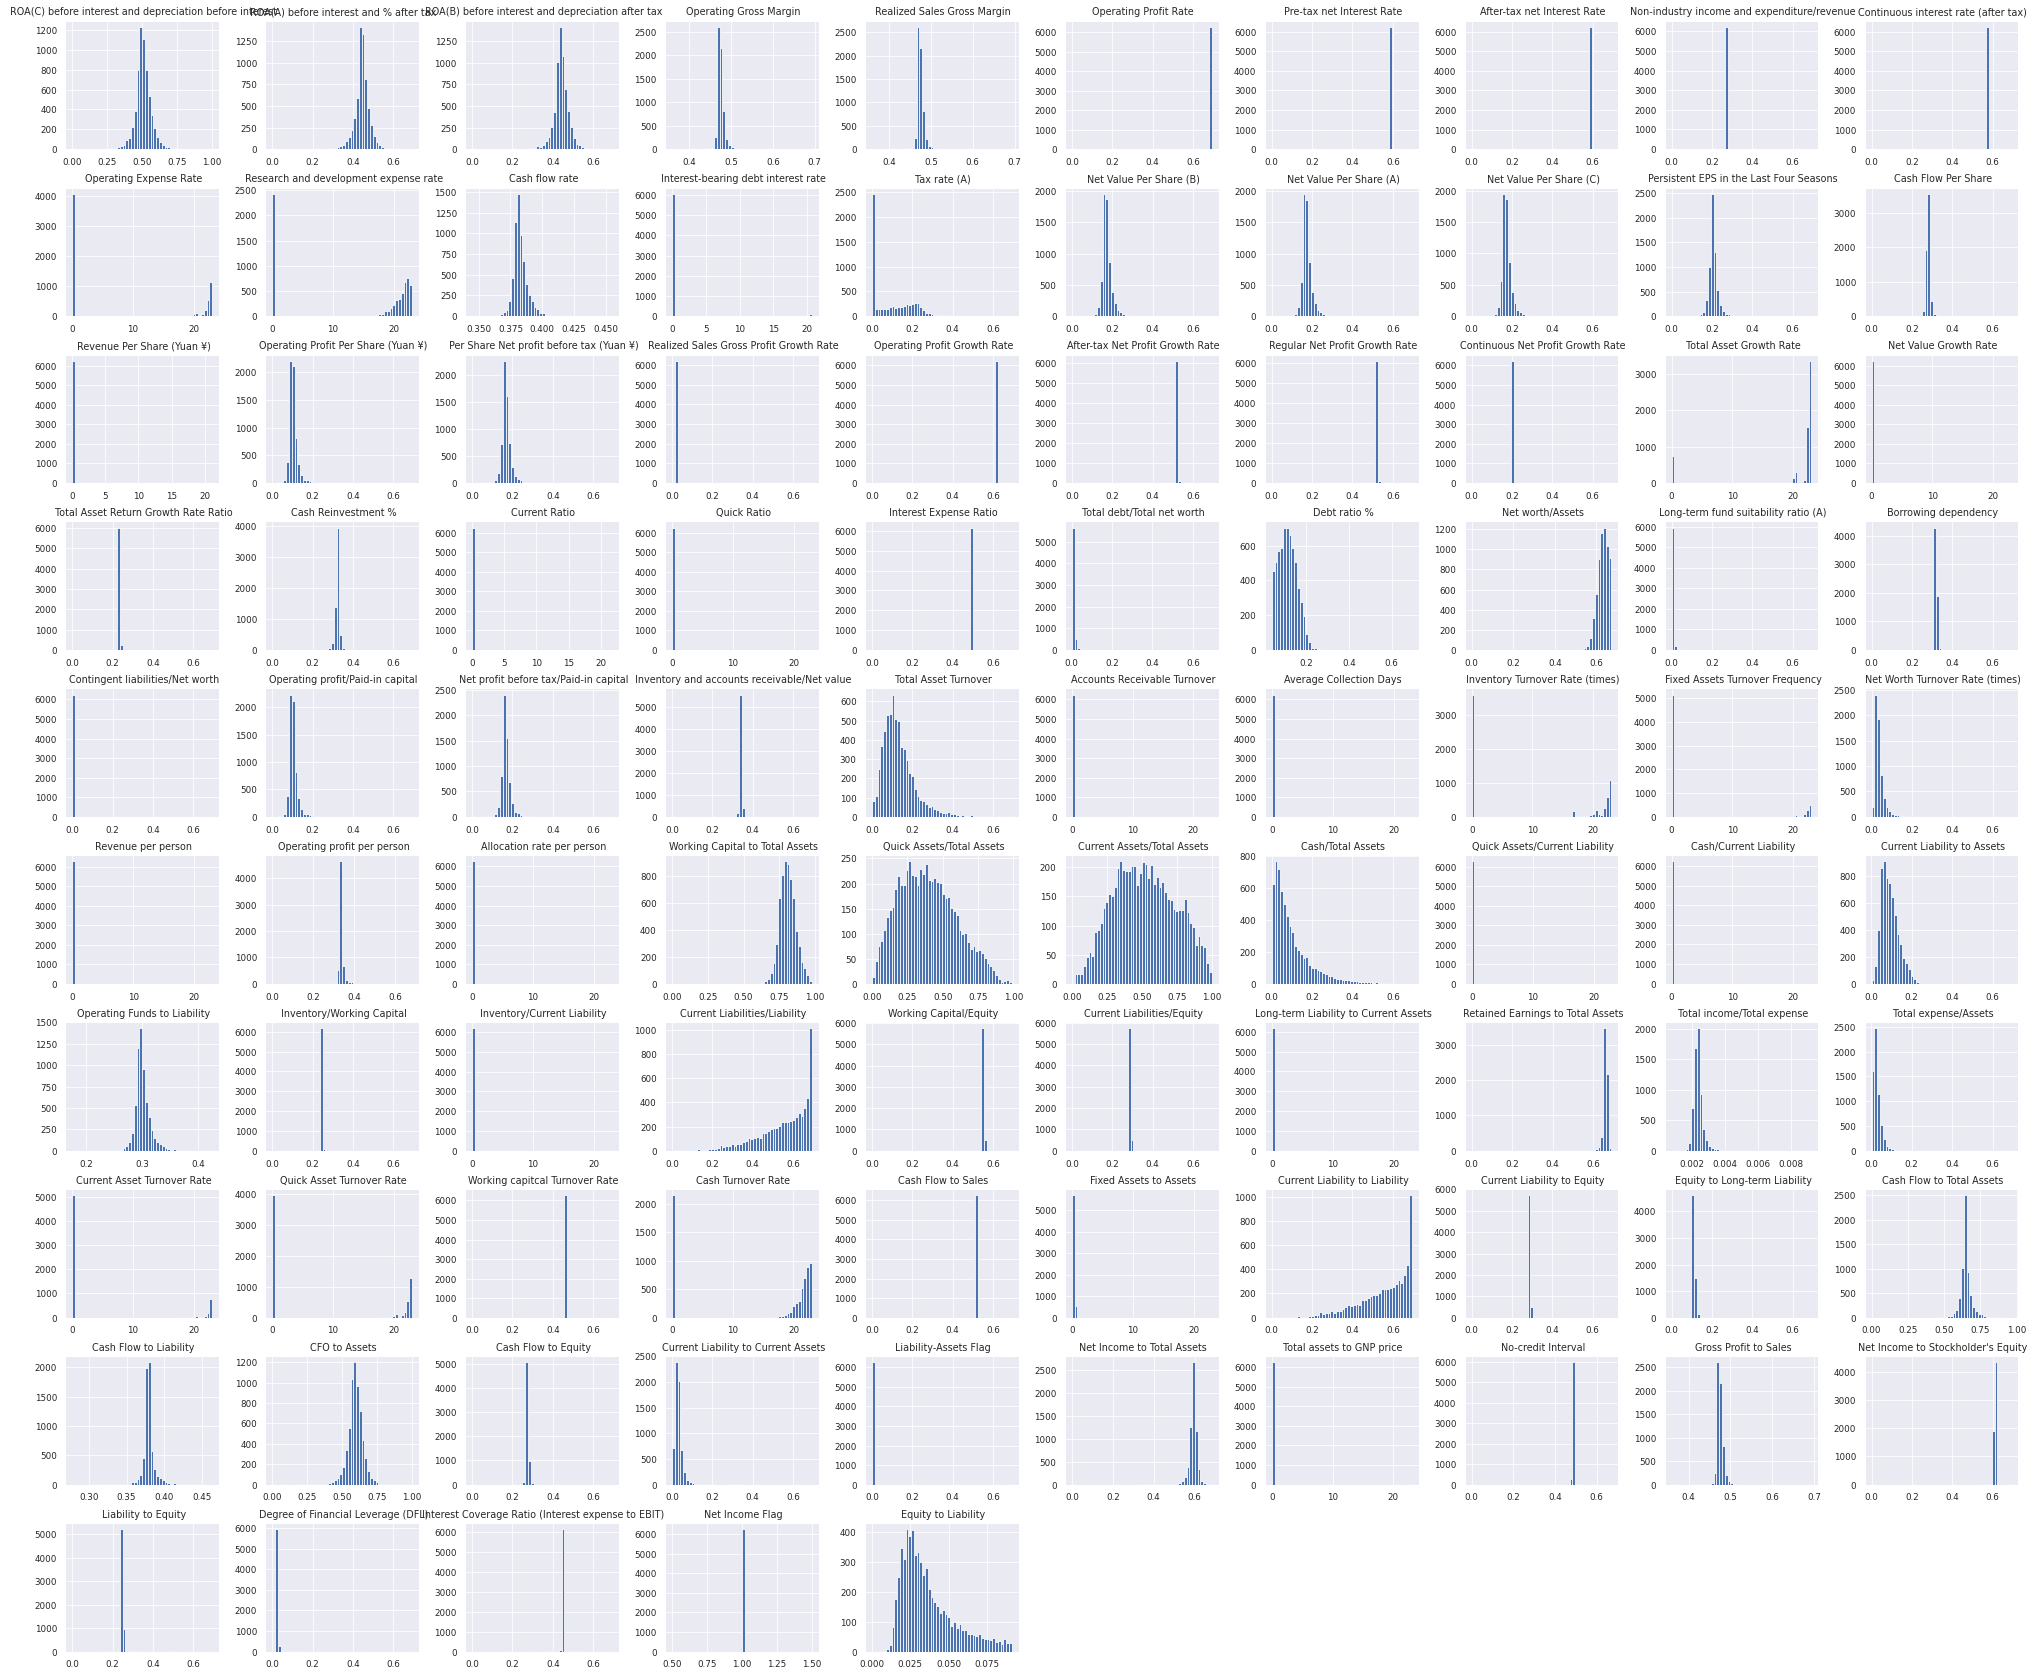

In [ ]:
data_norm.hist(figsize = (35,30),bins = 50)
plt.show()

In [ ]:
X_raw,X_test,y_raw,y_test  = train_test_split(data_norm,
                                              labels,
                                              test_size=0.2,
                                              stratify = labels,
                                              random_state = 42)

In [ ]:
sss = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

for train_index, test_index in sss.split(X_raw,y_raw):
    
    print("Train:", train_index, "Test:", test_index)
    X_train_sm, X_val_sm = X_raw.iloc[train_index], X_raw.iloc[test_index]
    y_train_sm, y_val_sm = y_raw.iloc[train_index], y_raw.iloc[test_index]

X_train_sm = X_train_sm.values
X_val_sm = X_val_sm.values
y_train_sm = y_train_sm.values
y_val_sm = y_val_sm.values

train_unique_label, train_counts_label = np.unique(y_train_sm, return_counts=True)
test_unique_label, test_counts_label = np.unique(y_val_sm, return_counts=True)
print('-' * 84)

print('Label Distributions: \n')
print(train_counts_label/ len(y_train_sm))
print(test_counts_label/ len(y_val_sm))

Train: [   0    1    2 ... 5011 5013 5014] Test: [  13   15   18 ... 5007 5012 5015]
Train: [   0    1    2 ... 5013 5014 5015] Test: [   4    6   10 ... 4996 5002 5006]
Train: [   0    1    3 ... 5013 5014 5015] Test: [   2    8   11 ... 4998 5003 5004]
Train: [   0    2    3 ... 5011 5012 5015] Test: [   1   26   35 ... 5010 5013 5014]
Train: [   1    2    4 ... 5013 5014 5015] Test: [   0    3    5 ... 4999 5001 5011]
------------------------------------------------------------------------------------
Label Distributions: 

[0.96536257 0.03463743]
[0.96510469 0.03489531]


In [ ]:
accuracy_lst_reg = []
precision_lst_reg = []
recall_lst_reg = []
f1_lst_reg = []
auc_lst_reg = []

log_reg_sm = LogisticRegression()

log_reg_params = {"penalty": ['l2'],
                  'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                  'class_weight': ['balanced',None],
                  'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)


for train, val in sss.split(X_train_sm, y_train_sm):
    pipeline_reg = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg)
    model_reg = pipeline_reg.fit(X_train_sm[train], y_train_sm[train])
    best_est_reg = rand_log_reg.best_estimator_
    prediction_reg = best_est_reg.predict(X_train_sm[val])
    
    accuracy_lst_reg.append(pipeline_reg.score(X_train_sm[val], y_train_sm[val]))
    precision_lst_reg.append(precision_score(y_train_sm[val], prediction_reg))
    recall_lst_reg.append(recall_score(y_train_sm[val], prediction_reg))
    f1_lst_reg.append(f1_score(y_train_sm[val], prediction_reg))
    auc_lst_reg.append(roc_auc_score(y_train_sm[val], prediction_reg))


print('---' * 45)
print('')
print('Logistic Regression (SMOTE) results:')
print('')
print("accuracy: {}".format(np.mean(accuracy_lst_reg)))
print("precision: {}".format(np.mean(precision_lst_reg)))
print("recall: {}".format(np.mean(recall_lst_reg)))
print("f1: {}".format(np.mean(f1_lst_reg)))
print('')
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------

Logistic Regression (SMOTE) results:

accuracy: 0.8440098384176544
precision: 0.15256023319529918
recall: 0.7341269841269841
f1: 0.25096328712266885

---------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
label = ['Fin.Stable', 'Fin.Unstable']
pred_reg_sm = best_est_reg.predict(X_val_sm)
print(classification_report(y_val_sm, pred_reg_sm, target_names=label))

              precision    recall  f1-score   support

  Fin.Stable       0.99      0.85      0.92       968
Fin.Unstable       0.17      0.86      0.28        35

    accuracy                           0.85      1003
   macro avg       0.58      0.85      0.60      1003
weighted avg       0.97      0.85      0.89      1003



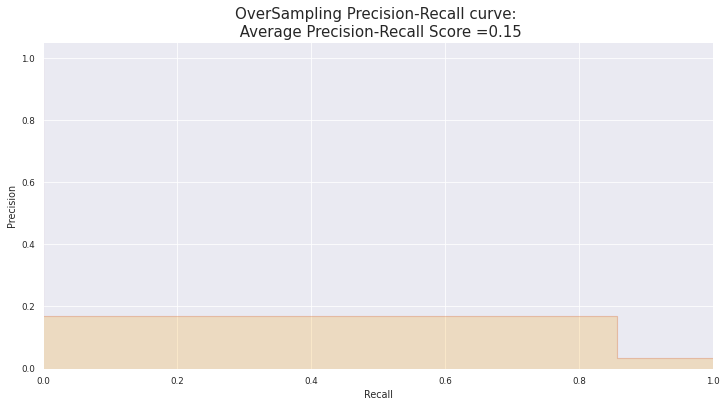

In [ ]:
y_score_reg = best_est_reg.predict(X_val_sm)

average_precision = average_precision_score(y_val_sm, y_score_reg)

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(y_val_sm, y_score_reg)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=15)

plt.show()

In [ ]:
accuracy_lst_rfc = []
precision_lst_rfc = []
recall_lst_rfc = []
f1_lst_rfc = []
auc_lst_rfc = []

rfc_sm = RandomForestClassifier()

rfc_params = {'max_features' : ['auto', 'sqrt', 'log2'],
              'random_state' : [42],
              'class_weight' : ['balanced','balanced_subsample'],
              'criterion' : ['gini', 'entropy'],
              'bootstrap' : [True,False]}
    
rand_rfc = RandomizedSearchCV(rfc_sm, rfc_params, n_iter=4)

for train, val in sss.split(X_train_sm, y_train_sm):
    pipeline_rfc = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_rfc) 
    model_rfc = pipeline_rfc.fit(X_train_sm, y_train_sm)
    best_est_rfc = rand_rfc.best_estimator_
    prediction_rfc = best_est_rfc.predict(X_train_sm[val])
    
    accuracy_lst_rfc.append(pipeline_rfc.score(X_train_sm[val], y_train_sm[val]))
    precision_lst_rfc.append(precision_score(y_train_sm[val], prediction_rfc))
    recall_lst_rfc.append(recall_score(y_train_sm[val], prediction_rfc))
    f1_lst_rfc.append(f1_score(y_train_sm[val], prediction_rfc))
    auc_lst_rfc.append(roc_auc_score(y_train_sm[val], prediction_rfc))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst_rfc)))
print("precision: {}".format(np.mean(precision_lst_rfc)))
print("recall: {}".format(np.mean(recall_lst_rfc)))
print("f1: {}".format(np.mean(f1_lst_rfc)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 1.0
precision: 1.0
recall: 1.0
f1: 1.0
---------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
smote_prediction_rfc = best_est_rfc.predict(X_val_sm)
print(classification_report(y_val_sm, smote_prediction_rfc, target_names=label))

              precision    recall  f1-score   support

  Fin.Stable       0.98      0.98      0.98       968
Fin.Unstable       0.45      0.49      0.47        35

    accuracy                           0.96      1003
   macro avg       0.71      0.73      0.72      1003
weighted avg       0.96      0.96      0.96      1003



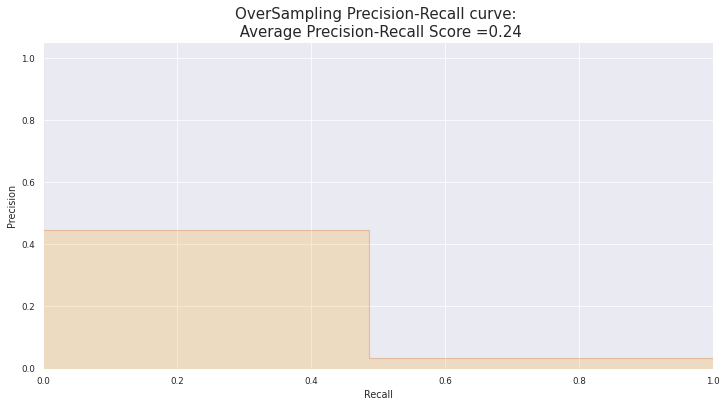

In [ ]:
y_score_rfc = best_est_rfc.predict(X_val_sm)

average_precision_rfc = average_precision_score(y_val_sm, y_score_rfc)

fig = plt.figure(figsize=(12,6))

precision_rfc, recall_rfc, _ = precision_recall_curve(y_val_sm, y_score_rfc)

plt.step(recall_rfc, precision_rfc, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall_rfc, precision_rfc, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision_rfc), fontsize=15)

plt.show()

In [ ]:
accuracy_lst_xgb = []
precision_lst_xgb = []
recall_lst_xgb = []
f1_lst_xgb = []
auc_lst_xgb = []

xgb_sm = xgb.XGBClassifier(random_state = 42)
xgb_params = {'eta' : [0.1,0.01,0.001],  
              'eval_metric': ['logloss'],
              'max_depth' : [3,6,9],
              'lambda' : [1,1.5,2],      
              'alpha' : [0,0.5,1]}       
        
rand_xgb = RandomizedSearchCV(xgb_sm, xgb_params, n_iter=4)

for train, val in sss.split(X_train_sm, y_train_sm):
    pipeline_xgb = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_xgb) 
    model_xgb = pipeline_xgb.fit(X_train_sm, y_train_sm)
    best_est_xgb = rand_xgb.best_estimator_
    prediction_xgb = best_est_xgb.predict(X_train_sm[val])
    
    accuracy_lst_xgb.append(pipeline_xgb.score(X_train_sm[val], y_train_sm[val]))
    precision_lst_xgb.append(precision_score(y_train_sm[val], prediction_xgb))
    recall_lst_xgb.append(recall_score(y_train_sm[val], prediction_xgb))
    f1_lst_xgb.append(f1_score(y_train_sm[val], prediction_xgb))
    auc_lst_xgb.append(roc_auc_score(y_train_sm[val], prediction_xgb))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst_xgb)))
print("precision: {}".format(np.mean(precision_lst_xgb)))
print("recall: {}".format(np.mean(recall_lst_xgb)))
print("f1: {}".format(np.mean(f1_lst_xgb)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 1.0
precision: 1.0
recall: 1.0
f1: 1.0
---------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
smote_prediction_xgb = best_est_xgb.predict(X_val_sm)
print(classification_report(y_val_sm, smote_prediction_xgb, target_names=label))

              precision    recall  f1-score   support

  Fin.Stable       0.98      0.96      0.97       968
Fin.Unstable       0.35      0.54      0.42        35

    accuracy                           0.95      1003
   macro avg       0.66      0.75      0.70      1003
weighted avg       0.96      0.95      0.95      1003



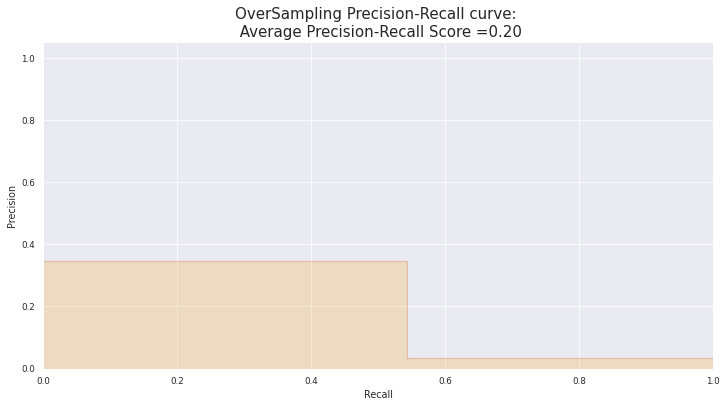

In [ ]:
y_score_xgb = best_est_xgb.predict(X_val_sm)

average_precision_xgb = average_precision_score(y_val_sm, y_score_xgb)

fig = plt.figure(figsize=(12,6))

precision_xgb, recall_xgb, _ = precision_recall_curve(y_val_sm, y_score_xgb)

plt.step(recall_xgb, precision_xgb, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall_xgb, precision_xgb, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision_xgb), fontsize=15)

plt.show()

In [ ]:
accuracy_lst_cat = []
precision_lst_cat = []
recall_lst_cat = []
f1_lst_cat = []
auc_lst_cat = []

cat_sm = CatBoostClassifier(verbose = 0)

cat_params = {'eval_metric': ['F1'],
              'iterations': [100,500,1000],
              'learning_rate' : [0.1,0.01,0.001],
              'random_seed' : [42],
              'auto_class_weights' : ['Balanced','SqrtBalanced']
             }
    
    
rand_cat = RandomizedSearchCV(cat_sm, cat_params, n_iter=4)


for train, val in sss.split(X_train_sm, y_train_sm):
    pipeline_cat = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_cat)
    model_cat = pipeline_cat.fit(X_train_sm, y_train_sm)
    best_est_cat = rand_cat.best_estimator_
    prediction_cat = best_est_cat.predict(X_train_sm[val])
    
    accuracy_lst_cat.append(pipeline_cat.score(X_train_sm[val], y_train_sm[val]))
    precision_lst_cat.append(precision_score(y_train_sm[val], prediction_cat))
    recall_lst_cat.append(recall_score(y_train_sm[val], prediction_cat))
    f1_lst_cat.append(f1_score(y_train_sm[val], prediction_cat))
    auc_lst_cat.append(roc_auc_score(y_train_sm[val], prediction_cat))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst_cat)))
print("precision: {}".format(np.mean(precision_lst_cat)))
print("recall: {}".format(np.mean(recall_lst_cat)))
print("f1: {}".format(np.mean(f1_lst_cat)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 1.0
precision: 1.0
recall: 1.0
f1: 1.0
---------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
smote_prediction_cat = best_est_cat.predict(X_val_sm)
print(classification_report(y_val_sm, smote_prediction_cat, target_names=label))

              precision    recall  f1-score   support

  Fin.Stable       0.98      0.97      0.98       968
Fin.Unstable       0.40      0.54      0.46        35

    accuracy                           0.96      1003
   macro avg       0.69      0.76      0.72      1003
weighted avg       0.96      0.96      0.96      1003



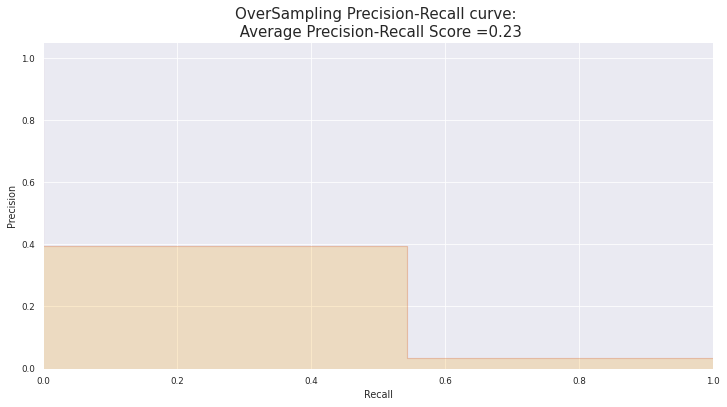

In [ ]:
smote_prediction_cat = best_est_cat.predict(X_val_sm)

average_precision_cat = average_precision_score(y_val_sm, smote_prediction_cat)

fig = plt.figure(figsize=(12,6))

precision_cat, recall_cat, _ = precision_recall_curve(y_val_sm, smote_prediction_cat)

plt.step(recall_cat, precision_cat, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall_cat, precision_cat, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision_cat), fontsize=15)

plt.show()

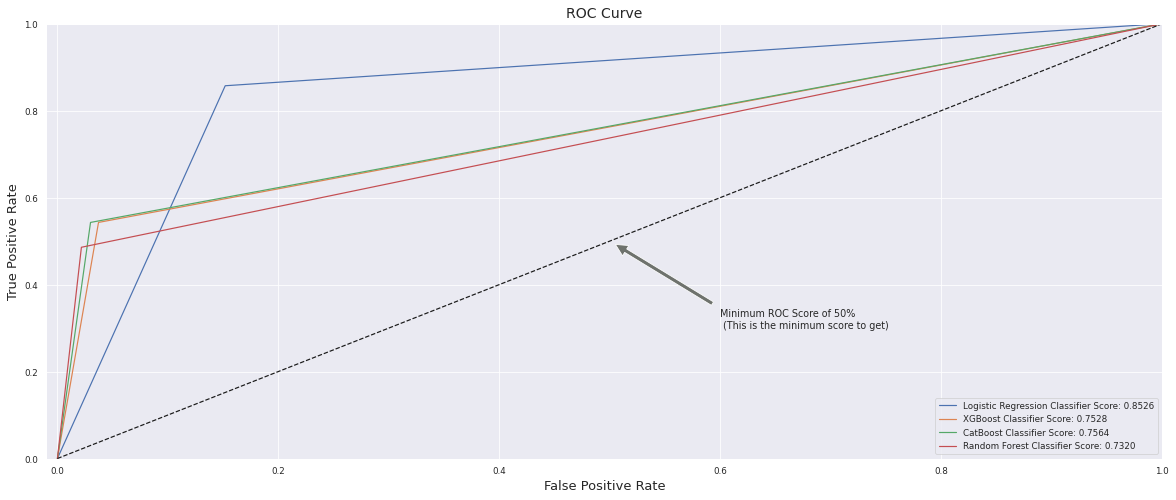

In [ ]:
from sklearn.metrics import roc_curve

log_fpr, log_tpr, log_thresold = roc_curve(y_val_sm, pred_reg_sm)
rfc_fpr, rfc_tpr, rfc_threshold = roc_curve(y_val_sm, smote_prediction_rfc)
xgb_fpr, xgb_tpr, xgb_thresold = roc_curve(y_val_sm, smote_prediction_xgb)
cat_fpr, cat_tpr, cat_thresold = roc_curve(y_val_sm, smote_prediction_cat)


def graph_roc_curve_multiple(log_fpr, log_tpr, rfc_fpr, rfc_tpr,xgb_fpr, xgb_tpr,cat_fpr, cat_tpr):
    plt.figure(figsize=(20,8))
    plt.title('ROC Curve', fontsize=14)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_val_sm, pred_reg_sm)))
    plt.plot(xgb_fpr, xgb_tpr, label='XGBoost Classifier Score: {:.4f}'.format(roc_auc_score(y_val_sm, smote_prediction_xgb)))
    plt.plot(cat_fpr, cat_tpr, label='CatBoost Classifier Score: {:.4f}'.format(roc_auc_score(y_val_sm, smote_prediction_cat)))
    plt.plot(rfc_fpr, rfc_tpr, label='Random Forest Classifier Score: {:.4f}'.format(roc_auc_score(y_val_sm, smote_prediction_rfc)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=13)
    plt.ylabel('True Positive Rate', fontsize=13)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, rfc_fpr, rfc_tpr,xgb_fpr, xgb_tpr,cat_fpr, cat_tpr)
plt.show()

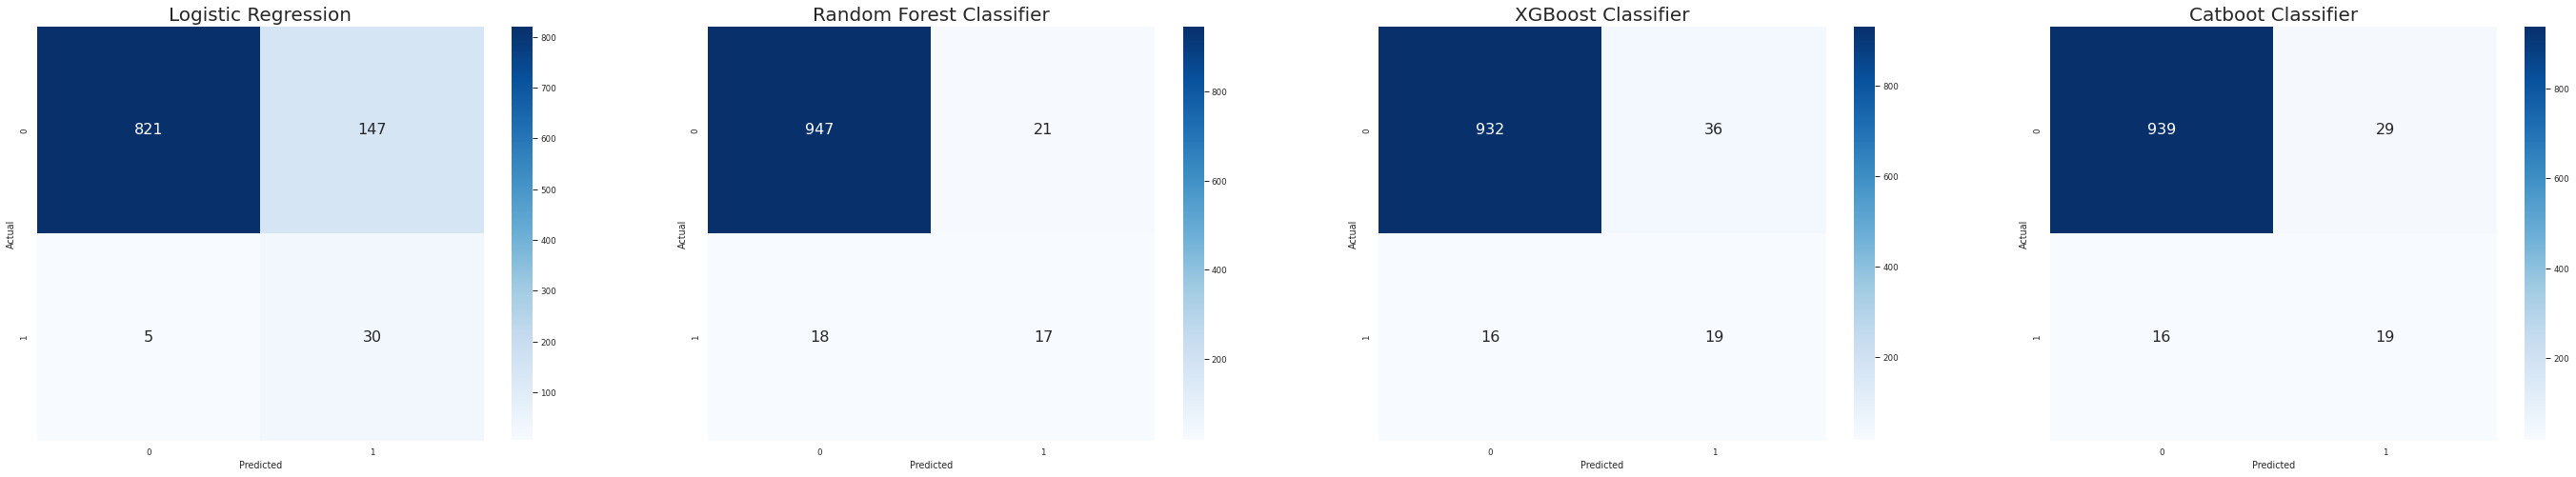

In [ ]:
conf_mx0 = confusion_matrix(y_val_sm,pred_reg_sm)
conf_mx1 = confusion_matrix(y_val_sm,smote_prediction_rfc)
conf_mx2 = confusion_matrix(y_val_sm,smote_prediction_xgb)
conf_mx3 = confusion_matrix(y_val_sm,smote_prediction_cat)

heat_cm0 = pd.DataFrame(conf_mx0, columns=np.unique(y_val_sm), index = np.unique(y_val_sm))
heat_cm0.index.name = 'Actual'
heat_cm0.columns.name = 'Predicted'

heat_cm1 = pd.DataFrame(conf_mx1, columns=np.unique(y_val_sm), index = np.unique(y_val_sm))
heat_cm1.index.name = 'Actual'
heat_cm1.columns.name = 'Predicted'

heat_cm2 = pd.DataFrame(conf_mx2, columns=np.unique(y_val_sm), index = np.unique(y_val_sm))
heat_cm2.index.name = 'Actual'
heat_cm2.columns.name = 'Predicted'

heat_cm3 = pd.DataFrame(conf_mx3, columns=np.unique(y_val_sm), index = np.unique(y_val_sm))
heat_cm3.index.name = 'Actual'
heat_cm3.columns.name = 'Predicted'

f, ax = plt.subplots(1, 4, figsize=(20,8))
f.subplots_adjust(left=None, bottom=None, right= 2, top=None, wspace=None, hspace= None)

sns.heatmap(heat_cm0, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g', ax = ax[0])
ax[0].set_title('Logistic Regression', fontsize = 20)
sns.heatmap(heat_cm1, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g', ax = ax[1])
ax[1].set_title('Random Forest Classifier', fontsize = 20)
sns.heatmap(heat_cm2, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g', ax = ax[2])
ax[2].set_title('XGBoost Classifier', fontsize = 20)
sns.heatmap(heat_cm3, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g', ax = ax[3])
ax[3].set_title('Catboot Classifier', fontsize = 20)

plt.show()

In [ ]:
test_pred_lr = best_est_reg.predict(X_test)
test_pred_cat = best_est_cat.predict(X_test)

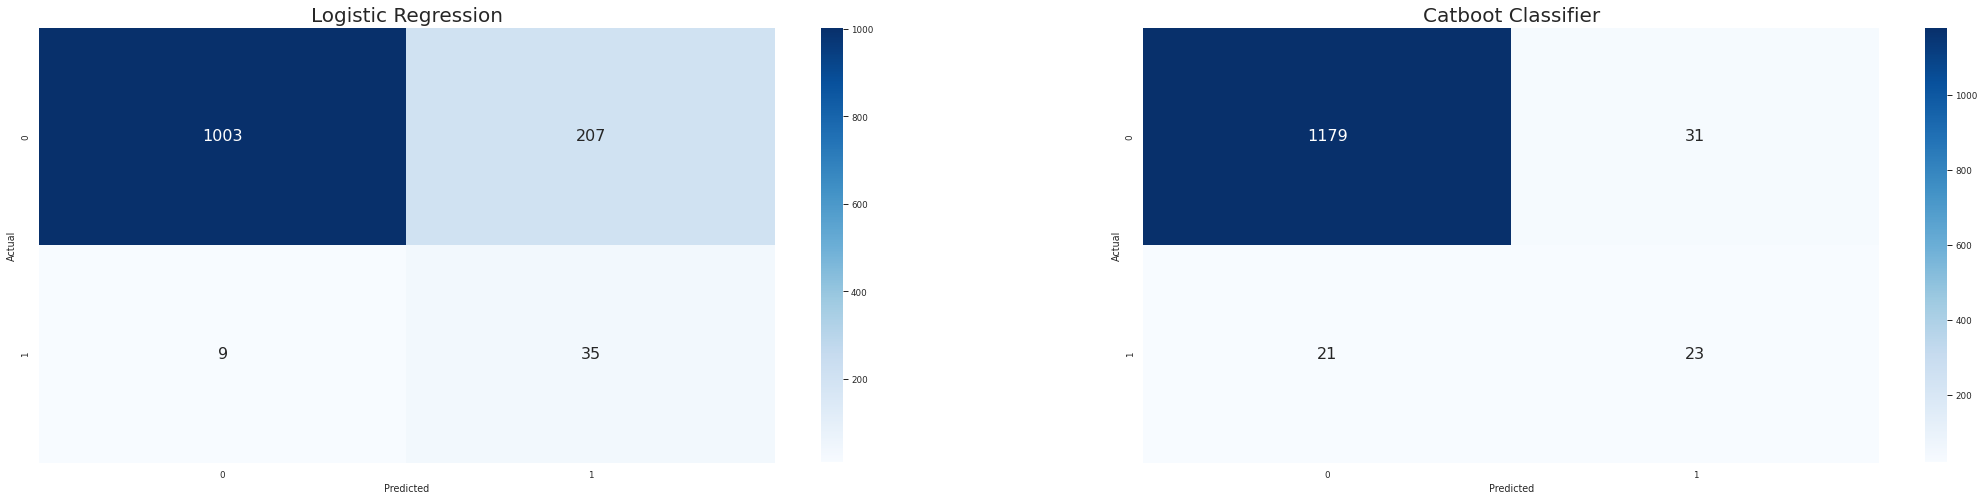

In [ ]:
conf_mx0 = confusion_matrix(y_test,test_pred_lr)
conf_mx1 = confusion_matrix(y_test,test_pred_cat)

heat_cm0 = pd.DataFrame(conf_mx0, columns=np.unique(y_test), index = np.unique(y_test))
heat_cm0.index.name = 'Actual'
heat_cm0.columns.name = 'Predicted'

heat_cm1 = pd.DataFrame(conf_mx1, columns=np.unique(y_test), index = np.unique(y_test))
heat_cm1.index.name = 'Actual'
heat_cm1.columns.name = 'Predicted'

f, ax = plt.subplots(1, 2, figsize=(15,8))
f.subplots_adjust(left=None, bottom=None, right= 2, top=None, wspace=None, hspace= None)

sns.heatmap(heat_cm0, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g', ax = ax[0])
ax[0].set_title('Logistic Regression', fontsize = 20)
sns.heatmap(heat_cm1, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g', ax = ax[1])
ax[1].set_title('Catboot Classifier', fontsize = 20)

plt.show()

In [ ]:
print(classification_report(y_test, test_pred_lr, target_names=label))

              precision    recall  f1-score   support

  Fin.Stable       0.99      0.83      0.90      1210
Fin.Unstable       0.14      0.80      0.24        44

    accuracy                           0.83      1254
   macro avg       0.57      0.81      0.57      1254
weighted avg       0.96      0.83      0.88      1254



In [ ]:
print(classification_report(y_test, test_pred_cat, target_names=label))

              precision    recall  f1-score   support

  Fin.Stable       0.98      0.97      0.98      1210
Fin.Unstable       0.43      0.52      0.47        44

    accuracy                           0.96      1254
   macro avg       0.70      0.75      0.72      1254
weighted avg       0.96      0.96      0.96      1254

